# Regression Models with Pycaret

#### Get information

In [1]:
from pycaret.regression import *
import mlflow

In [2]:
mlflow.__version__

'2.11.1'

In [3]:
# load the dataset from pycaret
from pycaret.datasets import get_data
dataset = get_data('diamond')

,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price
0,1.10,Ideal,H,SI1,VG,EX,GIA,5169
1,0.83,Ideal,H,VS1,ID,ID,AGSL,3470
2,0.85,Ideal,H,SI1,EX,EX,GIA,3183
3,0.91,Ideal,E,SI1,VG,VG,GIA,4370
4,0.83,Ideal,G,SI1,EX,EX,GIA,3171


#### EDA

In [4]:
dataset = get_data('diamond', profile=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
data = dataset.sample(frac=0.9, random_state=786)
data_unseen = dataset.drop(data.index)

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (5400, 8)
Unseen Data For Predictions (600, 8)


#### Preprocessing

In [7]:
# initialize setup

exp_reg102 = setup(data=data, target='Price', 
                   session_id=123,
                   normalize=True, 
                   transformation=True, transform_target=True, 
                   remove_multicollinearity=True, multicollinearity_threshold=0.95, 
                   bin_numeric_features=['Carat Weight'],
                   log_experiment=True, experiment_name='diamond_exp') 

,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(5400, 8)"
4,Transformed data shape,"(5400, 28)"
5,Transformed train set shape,"(3779, 28)"
6,Transformed test set shape,"(1621, 28)"
7,Numeric features,1
8,Categorical features,6
9,Preprocess,True


2024/03/18 16:11:55 INFO mlflow.tracking.fluent: Experiment with name 'diamond_exp' does not exist. Creating a new experiment.


#### Model Training

In [8]:
best_model = compare_models(exclude = ['ransac'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,1707.9544,5903344.1271,2417.2365,0.9413,0.2225,0.1887,0.2340
xgboost,Extreme Gradient Boosting,1683.7355,6252332.6383,2483.1289,0.9384,0.2260,0.1856,0.1760
lightgbm,Light Gradient Boosting Machine,1660.9066,6358156.8678,2495.2445,0.9377,0.2235,0.1842,0.4880
rf,Random Forest Regressor,1741.3787,7137302.0316,2652.7687,0.9301,0.2402,0.1914,0.3670
et,Extra Trees Regressor,1899.5518,8861962.0801,2964.1057,0.9123,0.2605,0.2042,0.3810
dt,Decision Tree Regressor,1917.2621,9348381.9398,3041.8356,0.9078,0.2611,0.2045,0.1470
huber,Huber Regressor,2459.0362,13448255.5674,3652.8315,0.8665,0.2773,0.2450,0.1660
ridge,Ridge Regression,2525.0260,13756677.4502,3694.6290,0.8634,0.2745,0.2399,0.1480
br,Bayesian Ridge,2528.8946,13826571.1684,3703.9075,0.8627,0.2745,0.2399,0.1610
lr,Linear Regression,2532.9625,13997138.5028,3724.3752,0.8612,0.2750,0.2402,1.2950


In [9]:
tuned_best = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1679.0225,5267570.3128,2295.1188,0.9422,0.2189,0.1822
1,1966.8693,12919474.9145,3594.3671,0.9010,0.2313,0.1945
2,1836.1748,7936481.8015,2817.1762,0.9272,0.2408,0.2054
3,1679.5022,5620524.0428,2370.7644,0.9380,0.2139,0.1786
4,1723.3571,5921593.8542,2433.4325,0.9261,0.2317,0.1982
5,1904.1648,13019205.0876,3608.2136,0.8889,0.2263,0.1933
6,1849.4508,8032177.3277,2834.1096,0.9245,0.2285,0.1930
7,1364.8422,4934572.8565,2221.3898,0.9376,0.1954,0.1531
8,1799.9373,7083354.7602,2661.4573,0.9304,0.2253,0.1871


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


#### Individual model training

In [10]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1631.2197,4764978.7229,2182.8831,0.9477,0.2273,0.1848
1,1786.1408,8517522.8962,2918.4796,0.9347,0.2257,0.1875
2,1678.9553,5196108.3842,2279.4974,0.9523,0.2389,0.1997
3,1641.9054,4585709.6133,2141.4270,0.9494,0.2129,0.1765
4,1669.5466,6287592.8249,2507.5073,0.9216,0.2293,0.1919
5,1739.9398,8399345.6706,2898.1625,0.9283,0.2197,0.1862
6,1846.1307,8981458.3319,2996.9081,0.9156,0.2294,0.1871
7,1254.5156,3385188.9328,1839.8883,0.9572,0.1903,0.1479
8,1651.8998,6412245.8029,2532.2413,0.9370,0.2195,0.1779


In [11]:
import numpy as np
lgbm_params = {'num_leaves': np.arange(10,200,10),
                        'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
                        'learning_rate': np.arange(0.1,1,0.1)
                        }

tuned_lightgbm = tune_model(lightgbm, 
                            custom_grid = lgbm_params)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1675.2714,5086398.1446,2255.3044,0.9442,0.2344,0.1883
1,1795.2791,8215553.0369,2866.2786,0.9370,0.2363,0.1923
2,1838.7086,7425749.0618,2725.0228,0.9319,0.2468,0.2060
3,1674.8863,5123457.3518,2263.5055,0.9435,0.2180,0.1780
4,1700.3237,6162104.8259,2482.3587,0.9231,0.2358,0.1948
5,1748.1738,8683121.7790,2946.7137,0.9259,0.2272,0.1892
6,1926.7462,10303603.5644,3209.9227,0.9032,0.2382,0.1893
7,1331.8388,4013445.1362,2003.3585,0.9492,0.1965,0.1521
8,1716.2054,6753901.5664,2598.8270,0.9337,0.2287,0.1845


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


### Evaluate model

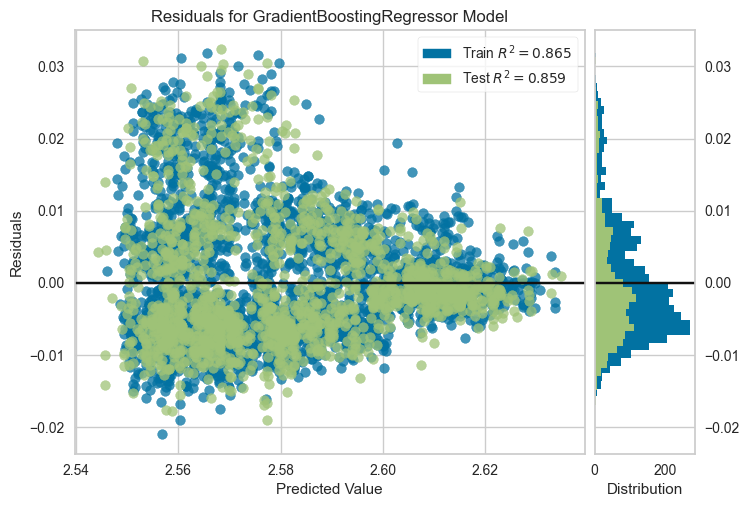

In [14]:
# check the residuals of trained model
plot_model(tuned_best, plot = 'residuals')

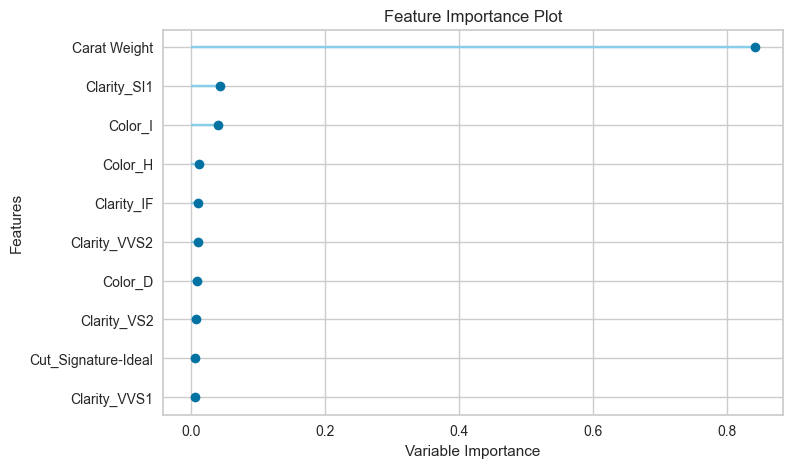

In [15]:
# check feature importance
plot_model(tuned_best, plot = 'feature')

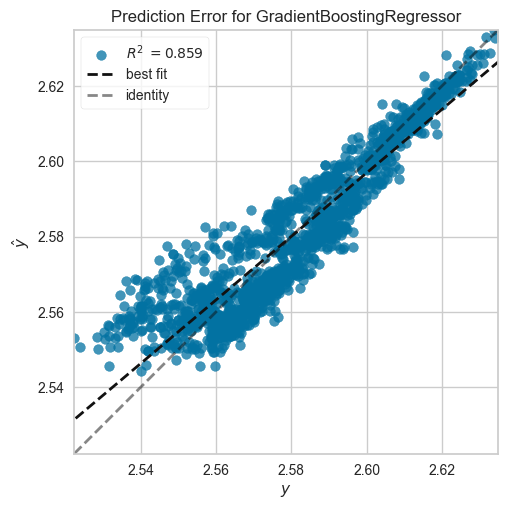

In [16]:
plot_model(tuned_best, plot = 'error')

In [17]:
evaluate_model(tuned_best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#### Evaluate model with test data

Before finalizing the model, it is recommended to perform a final check by predicting the test set and reviewing the evaluation metrics. All of the evaluation metrics we've seen above are cross-validated results based **only on the training set (94%)**. Now, we are going to use the test data to see if the performance is different and there may be overfitting.

In [18]:
predict_model(tuned_best);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1760.3773,6164870.2398,2482.9157,0.9438,0.2237,0.1886


### Finish to put into production

In [19]:
# finalize the model
final_best = finalize_model(tuned_best)

# save model to disk
save_model(final_best, 'models/diamond-pipeline')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('target_transformation',
                  TransformerWrapperWithInverse(transformer=TargetTransformer(estimator=PowerTransformer(standardize=False)))),
                 ('numerical_imputer',
                  TransformerWrapper(include=['Carat Weight'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Cut', 'Color', 'Clarity',
                                              'P...
                                     transformer=KBinsDiscretizer(encode='ordinal',
                                                                  strategy='kmeans'))),
                 ('transformation',
                  TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('clean_column_names',
                  TransformerWrappe

### Predictions with unseen data

In [20]:
unseen_predictions = predict_model(final_best, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,1789.0088,6578248.0595,2564.8096,0.9361,0.2227,0.1853


,Carat Weight,Cut,Color,Clarity,Polish,Symmetry,Report,Price,prediction_label
0,1.53,Ideal,E,SI1,ID,ID,AGSL,12791,10166.494098
1,1.50,Fair,F,SI1,VG,VG,GIA,10450,9562.490920
2,1.01,Good,E,SI1,G,G,GIA,5161,4360.275460
3,2.51,Very Good,G,VS2,VG,VG,GIA,34361,30857.551363
4,1.01,Good,I,SI1,VG,VG,GIA,4238,3756.506116


In [ ]:
from pycaret.utils import check_metric
check_metric(unseen_predictions.Price, unseen_predictions.Label, 'R2')